<a href="https://jupyterhub.user.eopf.eodc.eu/hub/user-redirect/git-pull?repo=https://github.com/eopf-toolkit/eopf-101&branch=main&urlpath=lab/tree/eopf-101/66_use_overviews.ipynb" target="_blank">
  <button style="background-color:#0072ce; color:white; padding:0.6em 1.2em; font-size:1rem; border:none; border-radius:6px; margin-top:1em;">
    🚀 Launch this notebook in JupyterLab
  </button>
</a>

### Introduction

In this notebook, we will explore and visualize the **multiscale overview pyramid** created in the previous tutorial ([65_create_overviews.ipynb](65_create_overviews.ipynb)). Building upon what we learned about creating overviews, we will now focus on how to use them effectively for interactive visualization and exploration of large Earth Observation datasets.

Overviews enable efficient visualization by providing progressively coarser representations of the data, allowing us to quickly navigate and explore large satellite images without loading the full-resolution dataset every time.

### What we will learn

- 📊 How to parse and inspect the multiscales metadata structure?
- 🔍 How to load different overview levels dynamically from the Zarr hierarchy?
- 🎨 How to create RGB composites at different resolutions for visualization?
- 🖱️ How to build interactive widgets for exploring zoom levels?
- 🗺️ How to create an interactive web map with automatic level selection?

### Prerequisites

This notebook assumes you have:
- Completed **[65_create_overviews.ipynb](65_create_overviews.ipynb)** (created the overview hierarchy)
- Successfully generated multiscales metadata for Sentinel-2 L2A reflectance data
- A local Zarr dataset with overview levels stored in the `overviews/` subfolder

Required packages:
- **Core**: `xarray`, `zarr`, `numpy`, `pandas`
- **Visualization**: `matplotlib`, `ipywidgets`
- **Web mapping**: `ipyleaflet`, `pyproj`, `pillow`

If you need to install these dependencies, run:
```bash
uv sync --all-extras
```

<hr>

#### Import libraries

In [ ]:
import xarray as xr, os, json, pandas as pd, warnings
from ipywidgets import interact, IntSlider
warnings.filterwarnings("ignore")

<hr>

## Understanding the Overview Hierarchy

The first step in working with overviews is to understand their structure. In the previous tutorial, we created a multiscale pyramid with several levels (L0 through L7), where each level represents the data at a different resolution.

Let's load the dataset and examine the **multiscales metadata** that describes this hierarchy. This metadata follows the GeoZarr Overviews specification and contains information about:
- Which levels exist and where they are stored in the Zarr hierarchy
- How each level relates to others (parent-child relationships through `derived_from`)
- The spatial resolution (`cell_size`) of each level in meters
- What resampling method was used to create each level

### Opening the dataset

We start by opening the dataset at the group level where our overviews are stored. This is the same path we used in the previous tutorial when creating the overviews (`measurements/reflectance/r10m`).

In [49]:
local_zarr_path = "output/S2A_MSIL2A_20250831T135741_N0511_R010_T26WPD_20250831T185012.zarr"
variable_group_path = "measurements/reflectance/r10m"
dataset_path = os.path.join(local_zarr_path, variable_group_path)
dataset = xr.open_dataset(dataset_path, engine="zarr")  # Load dataset
print(f"Dataset: {dict(dataset.dims)} | Variables: {list(dataset.data_vars)} | Multiscales: {'multiscales' in dataset.attrs}\n")

Dataset: {'y': 10980, 'x': 10980} | Variables: ['b02', 'b03', 'b04', 'b08'] | Multiscales: True



The output confirms that our dataset has dimensions of 10,980 × 10,980 pixels and contains four spectral bands (b02, b03, b04, b08), along with the multiscales metadata we created in the previous tutorial.

### Parsing the multiscales metadata

The `multiscales` attribute contains all the information about our overview pyramid. Let's parse it into a table format using pandas to make it easier to understand.

Each row in the table represents one resolution level:
- **id**: Level identifier (L0, L1, L2, etc.)
- **path**: Where this level is stored in the Zarr hierarchy (`.` means current group, `overviews/L*` means subfolder)
- **cell_size**: Spatial resolution in meters as `[x_res, y_res]`
- **derived_from**: Which parent level this was created from
- **factors**: Downsampling factors applied as `[y_factor, x_factor]`
- **resampling_method**: How pixels were aggregated (average, nearest, etc.)

In [50]:
# Parse multiscales metadata
multiscales= dataset.attrs["multiscales"]
layout_df = pd.DataFrame(multiscales["layout"])
print("Overview Level Hierarchy:")
display(layout_df)

Overview Level Hierarchy:


,id,path,cell_size,derived_from,factors,resampling_method
0,L0,.,"[10.0, 10.0]",NaN,NaN,NaN
1,L1,overviews/L1,"[20.0, 20.0]",L0,"[2, 2]",average
2,L2,overviews/L2,"[40.0, 40.0]",L1,"[4, 4]",average
3,L3,overviews/L3,"[80.0, 80.0]",L2,"[8, 8]",average
4,L4,overviews/L4,"[160.0, 160.0]",L3,"[16, 16]",average
5,L5,overviews/L5,"[320.0, 320.0]",L4,"[32, 32]",average
6,L6,overviews/L6,"[640.0, 640.0]",L5,"[64, 64]",average
7,L7,overviews/L7,"[1280.0, 1280.0]",L6,"[128, 128]",average


Notice the hierarchical structure:
- **L0** has `path="."`, meaning it references the native data at the current group level (no data duplication)
- **L1-L7** have `path="overviews/L*"`, stored in the `overviews/` subfolder we created
- Each level is progressively coarser: L1 is 2× downsampled, L2 is 4×, L3 is 8×, and so on
- The `cell_size` doubles at each level: 10m → 20m → 40m → 80m → 160m → 320m → 640m → 1280m
- All levels use `average` resampling, which is appropriate for continuous reflectance data

<hr>

## Loading Overview Levels

Now that we understand the structure from the metadata, let's load each overview level into memory. We'll iterate through the layout array from the multiscales metadata and open each level as a separate xarray Dataset.

The code below:
1. Creates an empty dictionary to store all overview datasets
2. Loops through each entry in the layout metadata
3. Constructs the full path by joining the base path with the level's relative path
4. Opens each level using `xr.open_dataset()` with the Zarr engine
5. Displays the dimensions and downsampling factor for each level

In [51]:
overview_datasets = {}  # Dictionary to store all levels
for entry in multiscales["layout"]:
    level_id, level_path = entry["id"], entry["path"]
    full_path = os.path.normpath(os.path.join(dataset_path, level_path))
    overview_datasets[level_id] = xr.open_dataset(full_path, engine="zarr")
    print(f"Loaded  {level_id}: {overview_datasets[level_id]['b02'].shape[0]:5d} × {overview_datasets[level_id]['b02'].shape[1]:5d} pixels")

Loaded  L0: 10980 × 10980 pixels
Loaded  L1:  5490 ×  5490 pixels
Loaded  L2:  2745 ×  2745 pixels
Loaded  L3:  1372 ×  1372 pixels
Loaded  L4:   686 ×   686 pixels
Loaded  L5:   343 ×   343 pixels
Loaded  L6:   171 ×   171 pixels
Loaded  L7:    85 ×    85 pixels


Observe how the dimensions decrease at each level:
- **L0**: 10,980 × 10,980 pixels (full resolution, ~121 megapixels)
- **L1**: 5,490 × 5,490 pixels (half resolution, ~30 megapixels)
- **L2**: 2,745 × 2,745 pixels (quarter resolution, ~7.5 megapixels)
- **L7**: 85 × 85 pixels (128× downsampled, ~7 kilopixels)

Lower resolution levels are much faster to load and visualize, making them ideal for quick previews, thumbnails, or zoomed-out views. This is the key benefit of the overview pyramid structure.

<hr>

## Visualization of Overviews

### Creating RGB Composites

To visualize our Sentinel-2 data, we'll create **RGB true-color composites** by combining three spectral bands:
- **Red channel**: Band 4 (b04) at 664 nm - sensitive to red wavelengths
- **Green channel**: Band 3 (b03) at 560 nm - sensitive to green wavelengths  
- **Blue channel**: Band 2 (b02) at 490 nm - sensitive to blue wavelengths

However, raw reflectance values (typically ranging from 0 to ~0.4) don't display well directly. We need to apply **contrast enhancement** through percentile stretching to make features visible and create visually appealing images.

### Percentile stretching for contrast enhancement

The normalize() helper function below performs **percentile-based contrast stretching**, a standard technique in remote sensing visualization. It works by:

1. Filtering out NaN (fill) values, which are common in Earth Observation data due to clouds, partial coverage, or sensor issues
2. Computing the 2nd and 98th percentile values of the valid data
3. Linearly mapping these percentile values to 0 and 1 respectively
4. Clipping any values outside this range

This approach is robust to outliers (very bright or dark pixels) and produces visually balanced images. **Critical note**: Proper NaN handling is essential - if NaN values aren't filtered out, `np.percentile()` returns NaN, causing the entire image to display as white/blank.

In [52]:
    # Normalize each channel using percentile stretch (2% - 98%)
def normalize(band):
    valid_pixels = band[~np.isnan(band)]  # ← ADD THIS LINE
    if len(valid_pixels) == 0:
        return np.zeros_like(band)
    p2, p98 = np.percentile(valid_pixels, [2, 98])  # ← USE valid_pixels
    if p98 == p2:
        return np.zeros_like(band)
    normalized = (band - p2) / (p98 - p2)
    return np.clip(normalized, 0, 1)

### Interactive visualization with zoom levels

Now let's create an **interactive visualization** that demonstrates the power of overviews. The widget below allows you to:

- **Move the slider** to switch between zoom levels (0 = highest resolution L0, 7 = lowest resolution L7)
- **Observe the performance difference**: Lower resolution levels (L5-L7) display almost instantly, while higher resolution levels take longer
- **Notice the quality tradeoff**: Higher levels show more detail but require more time to load and render

The function crops each image to the top-left quarter to make the display more responsive. Even with this cropping, L0 at full resolution would be 2,745 × 2,745 pixels, which is still quite large. This demonstrates why overviews are so valuable for interactive applications.

In [53]:

def visualize_level(i):
    """Show RGB composite for overview level (cropped top-left)."""
    ds = overview_datasets[f"L{i}"]                         # Select overview level
    r, g, b = [ds[b].values for b in ('b04', 'b03', 'b02')] # Extract RGB bands
    h, w = r.shape
    rgb = np.dstack([r, g, b])[:h//4, :w//4]                # Crop top-left quarter
    img = np.dstack([normalize(rgb[..., j]) for j in range(3)]) # Normalise bands
    fig, ax = plt.subplots(figsize=(4.5, 4.5))               # Set figure size
    ax.imshow(img)                                           # Display RGB image
    plt.show()
interact(visualize_level, i=IntSlider(min=0, max=7, value=4, description='Zoom Level')); # Interactive slider

interactive(children=(IntSlider(value=4, description='Zoom Level', max=7), Output()), _dom_classes=('widget-in…

<hr>

## Comparing Multiple Resolution Levels

To better understand the effect of downsampling, let's compare **multiple overview levels side-by-side**. This visual comparison helps us see:

- **How much spatial detail is lost** at each downsampling level
- **The tradeoff between image quality and file size/performance** - L2 is 16× smaller than L0 but still retains good detail
- **Which level is appropriate for different use cases**: L2 for regional analysis, L5 for quick previews, L7 for thumbnails

The function below displays three different levels (L2, L5, and L7) to show this progression from medium to very coarse resolution.

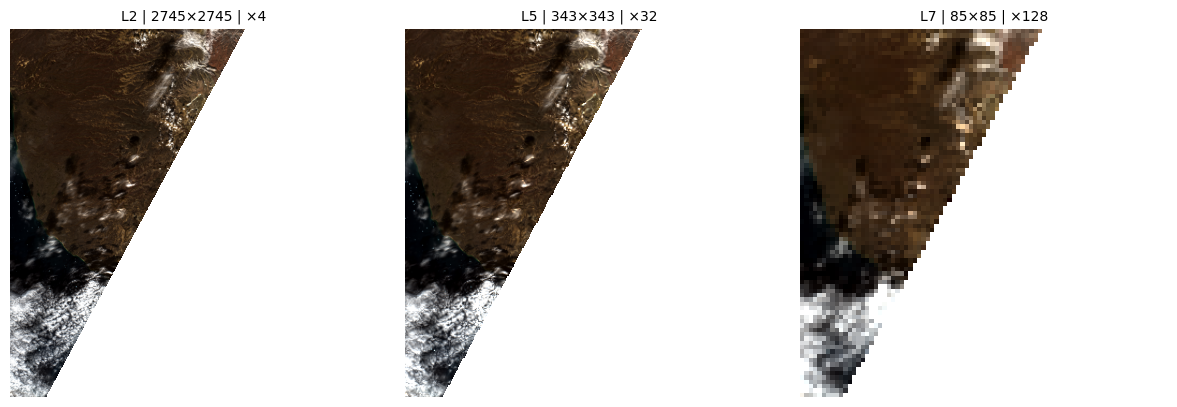

In [54]:
import matplotlib.pyplot as plt
import numpy as np

def show_levels(levels=(2, 5, 7)):
    """Display RGB composites for selected overview levels."""
    fig, axes = plt.subplots(1, len(levels), figsize=(12, 4))
    for ax, i in zip(axes, levels):
        ds = overview_datasets[f"L{i}"]                              # Select overview level
        rgb = np.dstack([ds[b].values for b in ('b04', 'b03', 'b02')]) # Stack RGB bands
        img = np.dstack([normalize(rgb[..., j]) for j in range(3)])     # Normalise
        ax.imshow(img); ax.axis("off")
        ax.set_title(f"L{i} | {rgb.shape[0]}×{rgb.shape[1]} | ×{2**i}", fontsize=10)
    plt.tight_layout(); plt.show()

show_levels()  # Show levels 0, 3, and 7

Notice the progressive loss of detail:
- **L2 (4× downsampled, 2745×2745 px)**: Retains good spatial detail, suitable for regional-scale visualization and analysis
- **L5 (32× downsampled, 343×343 px)**: Shows general patterns and major features but loses fine details like small fields or roads
- **L7 (128× downsampled, 85×85 px)**: Provides only a coarse overview showing large-scale patterns, useful for thumbnails or global context

This demonstrates why overviews are essential for **progressive rendering** in web mapping applications: the application can display L7 instantly for context, then progressively load L5, L3, L1 as the user waits, and finally load L0 when zoomed in for detailed analysis.

<hr>

## Interactive Web Map with Automatic Level Selection

Now let's put everything together by creating a **professional-like interactive web map** using ipyleaflet. This demonstrates a real-world application of overviews for geospatial visualization.

**Key features:**
- **Automatic level selection**: As you zoom in or out, the map automatically switches to the most appropriate overview level based on the current zoom level and ground resolution
- **Manual override**: Use the slider to manually select a specific level if you want to compare quality at different resolutions
- **Standard map controls**: Pan by clicking and dragging, zoom with mouse wheel or +/- buttons, switch basemap layers
- **Real-time information**: The label shows which level is displayed, its dimensions, cell size, and current ground resolution

The automatic selection algorithm works by:
1. Calculating the ground resolution (meters per pixel) at the current Web Mercator zoom level
2. Comparing it to the `cell_size` metadata of each overview level
3. Selecting the level whose `cell_size` is closest to the ground resolution

This ensures you always see the optimal balance between image quality and loading performance for your current view.

In [55]:
# Create Interactive Map with Smart Overview Level Selection
from ipyleaflet_multiscales import create_interactive_map

# Get metadata from the base level (L0)
metadata = overview_datasets["L0"].b02.attrs

# Define RGB band names (Sentinel-2: R=b04, G=b03, B=b02)
band_names = {"r": "b04", "g": "b03", "b": "b02"}

# Create the interactive map
# - initial_level=4: Start with L4 (good balance between quality and performance)
# - initial_zoom=10: Start zoomed to show the full area
# - band_names: Specify which bands to use for RGB composite
map_widget = create_interactive_map(
    overview_datasets=overview_datasets,
    multiscales=multiscales,
    metadata=metadata,
    initial_level=5,
    initial_zoom=7,
    band_names=band_names
)

# Display the map
# The label now shows: Level | Pixel dimensions | Cell size | Zoom | Ground resolution
display(map_widget)

🗺️  Creating interactive map with overview levels...
   Center: [70.6556, -22.7698] (lat/lon)
   Bounds: [[70.1988, -24.3543], [71.1124, -21.1852]]



Creating initial overlay for L5...
   Image shape: (343, 343, 3)
✓ Map created successfully!
   - Zoom in/out to automatically switch overview levels (smart selection based on cell_size)
   - Or use the slider to manually select a level



**How to use the interactive map:**

1. **Zoom in/out** using the +/- buttons, mouse wheel, or double-click - watch as the overview level automatically adjusts to match your zoom level
2. **Pan the map** by clicking and dragging to explore different areas
3. **Use the slider** to manually select a specific overview level if you want to compare quality
4. **Monitor the label** which shows:
   - **Level ID and dimensions**: e.g., "L5 (343×343 px)"
   - **Downsampling factor**: e.g., "32× downsampled"
   - **Cell size**: The spatial resolution in meters (e.g., "320.0m" means each pixel represents 320m on the ground)
   - **Current zoom**: The Web Mercator zoom level (typically 1-18)
   - **Ground resolution**: The actual pixel size at the current zoom level (e.g., "84.5m/px")

Try zooming in and out to see how the system automatically switches between levels to maintain both visual quality and responsiveness!

<hr>

## 💪 Now it is your turn

Now that you've learned how to visualize and interact with multiscale overviews, try these exercises to deepen your understanding:

### Task 1: Experiment with different band combinations
Instead of true color RGB (b04, b03, b02), try creating **false color composites** that highlight different features:
- **Color infrared (CIR)**: `{"r": "b08", "g": "b04", "b": "b03"}` - highlights vegetation in red tones
- **Agriculture composite**: `{"r": "b08", "g": "b03", "b": "b02"}` - emphasizes crop health and vigor
- **Urban analysis**: `{"r": "b08", "g": "b04", "b": "b02"}` - distinguishes urban areas from vegetation

Modify the `band_names` dictionary in the map creation code above and re-run the cell to see how different band combinations reveal different information about the landscape.

### Task 2: Apply this workflow to a different area
Go back to the previous tutorial ([65_create_overviews.ipynb](65_create_overviews.ipynb)) and create overviews for a different Sentinel-2 scene from your region of interest. Then return to this notebook and update the `local_zarr_path` variable to visualize your new dataset. Compare how the overview structure works for different landscapes (urban vs rural, mountainous vs flat, etc.).

### Task 3: Analyze the performance tradeoff
Measure how long it takes to load and display different overview levels. Add timing code like:
```python
import time
start = time.time()
visualize_level(0)  # L0 - full resolution
print(f"L0 took {time.time()-start:.2f} seconds")

start = time.time()
visualize_level(5)  # L5 - much coarser
print(f"L5 took {time.time()-start:.2f} seconds")
```
How much faster is L5 compared to L0? What about L7? At what level do you think the quality becomes too low for useful analysis?

## Conclusion

In this tutorial, we've learned how to **visualize and interact with multiscale overview pyramids** for GeoZarr datasets. We covered:

1. **Understanding the hierarchy**: How to parse and inspect multiscales metadata following the GeoZarr specification
2. **Loading levels dynamically**: How to iterate through the layout metadata and load different resolution levels
3. **Creating RGB composites**: How to combine spectral bands with proper contrast enhancement and NaN handling
4. **Interactive exploration**: How to build responsive widgets for exploring different zoom levels
5. **Professional web mapping**: How to create maps with automatic level selection based on zoom and ground resolution

**Key takeaways:**
- Overviews enable **efficient multi-scale visualization** by providing progressively coarser representations of large datasets
- **Automatic level selection** ensures optimal performance while maintaining visual quality appropriate for the current view
- **Proper NaN handling** is critical - failing to filter NaN values before percentile calculations causes white/blank displays
- The `cell_size` metadata enables **intelligent zoom-aware rendering** by matching overview resolution to ground resolution

These techniques are essential for building **interactive Earth Observation applications** that remain responsive even when working with very large satellite imagery datasets.

## What's next?

Now that you've mastered creating and visualizing GeoZarr overviews through tutorials 65 and 66, you can:

- **Apply these techniques to your own datasets**: Use the complete workflow on your Earth Observation data from any source (Sentinel-2, Landsat, commercial satellites, etc.)
- **Build custom web applications**: The `ipyleaflet_multiscales` module provides a foundation for developing interactive mapping tools tailored to your specific needs
- **Optimize for your use case**: Test different chunk sizes, compression algorithms, and scale factors to find the best balance between file size and access performance
- **Integrate with cloud platforms**: Host your overview-enhanced Zarr datasets on cloud object storage (S3, Azure Blob, Google Cloud Storage) for web-scale access

**Further resources:**
- [GeoZarr Specification](https://github.com/zarr-developers/geozarr-spec) - Full technical specification for GeoZarr extensions
- [xarray documentation](https://docs.xarray.dev/) - Comprehensive guide to working with labeled multi-dimensional arrays
